# PDF Table Reader
## Converts PDF table to CSV or Excel

using camelot package  
camelot package 0.8.0 was not compatible with new pdfminer, downgraded to 20200517 on conda

camelot imports successfully but PDF will not read due to "unsupported PNG filter 3" error  
need to downsize pdf and convert from image to text using nitro
* possible future project to integrate downsizing and OCR into this notebook

In [21]:
# import packages
import camelot
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os

In [3]:
# select file location
root = tk.Tk()
root.withdraw() # suppress root
root.wm_attributes('-topmost', 1) # bring window to the front
file_path = filedialog.askopenfilename()

# file_name = os.path.basename(file_path)
# folder_path = file_path.replace(file_name, '')

## Choose page numbers, then read and save PDF
#### User input for page numbers
Default is the full file  
user can input:   
* ranges separated by '-'
    * use 'end' for a range to go to the end of the file
* individual pages separated by ','
* or a combination  
  
characters other than numbers will throw and error

#### read_pdf function to read
#### user can select folder and save tables as an Excel file (one sheet or multiple) for further use

In [4]:
# specify pages
def get_pgs():
    """user input for page numbers to search for tables
    
    default is the full file
    
    user can input: 
        ranges separated by '-'
        individual pages separated by ','
        or a combination
        use 'end' for a range to go to the end of the file
    
    characters other than numbers will throw error
    
    Return: string of page ranges to print
    """
    p_str = input('Specify page numbers or press enter for full file: ')
    
    if p_str == '':
        print('full file')
        p_str = '1-end'
    else:
        print('page(s): ', p_str)
    
    return(p_str)

p_str = get_pgs()

Specify page numbers or press enter for full file: 1
page(s):  1


In [12]:
# read tables

# special parameters:

# table_regions - to specify area of pdf
#   otherwise the whole plan is converted to a table
#   plot full page, find coordinates from plot: 
#    top left and bottom right, ['x0,y0,x1,y1']

# strip_text - remove unwanted characters
#   =' .\n' to remove new line
#   =' ' to remove space
#   others possible

# copy_text - to fill all merged cells
#   =['v'] for vertical
#   =['h'] for horizontal (or both)

# line_scale - change sensitivity of lines detected
#   =15 is default
#   lower will detect less lines
#   higher will detect more, >150 will confuse text as lines
#   **faster to leave as default and make adjustments in dataframe after

tables = camelot.read_pdf(file_path, pages=p_str, flavor='lattice', table_regions=['270,1620,1430,300'], 
                          strip_text=[' \n'], copy_text=['v'])

In [13]:
# reults of read
print('number of tables found: ', len(tables))
print('\n\nFirst table parsing report: ')
print(tables[0].parsing_report)

number of tables found:  1


First table parsing report: 
{'accuracy': 99.79, 'whitespace': 27.66, 'order': 1, 'page': 1}


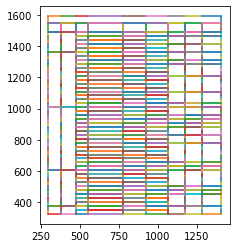

In [14]:
camelot.plot(tables[0], kind='grid')
plt.show()

In [34]:
# pandas dataframe
table_df_raw = tables[0].df
table_df_raw.head()

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
1,SOLDIERPILESCHEDULE,,,,,,,,
2,WalISegment,Quantity,PiIeNumber,PileCenterline,TopofSteelPileElevation(Feet),PileTipElevation(Feet),"Design""H""Height(Feet)","Embedment""D""Depth(Feet)",SoldierPileSection
3,A,5,1,1.68'LtSta10+02.00,1452.49,1437.40,,,
4,A,5,2,1.68'LtSta10+07.67,1452.53,1437.10,6,12,W16x67


In [59]:
# data cleaning

# change headers and remove unnecessary top rows
table = table_df_raw
header_row = 2
table.columns = table.iloc[header_row]
table = table.drop([0, 1, 2])
table = table.reset_index(drop=True)

# convert to integers
table['Quantity'] = table['Quantity'].astype(int)
table.rename(columns={'PiIeNumber':'PileNumber'}, inplace=True) # camelot thought l was I
table['PileNumber'] = table['PileNumber'].astype(int)

# replace commas with decimals
table['TopofSteelPileElevation(Feet)'] = [i.replace(',', '.') for i in table['TopofSteelPileElevation(Feet)']]
table['PileTipElevation(Feet)'] = [i.replace(',', '.') for i in table['PileTipElevation(Feet)']]

# convert to float
table[['TopofSteelPileElevation(Feet)', 'PileTipElevation(Feet)']] = table[['TopofSteelPileElevation(Feet)', 'PileTipElevation(Feet)']].astype(float)
table.head()

# probably faster to fill H and D cells in excel, but could also do that here

2,WalISegment,Quantity,PileNumber,PileCenterline,TopofSteelPileElevation(Feet),PileTipElevation(Feet),"Design""H""Height(Feet)","Embedment""D""Depth(Feet)",SoldierPileSection
0,A,5,1,1.68'LtSta10+02.00,1452.49,1437.40,,,
1,A,5,2,1.68'LtSta10+07.67,1452.53,1437.10,6,12,W16x67
2,A,5,3,1.68'LtSta10+14.67,1452.68,1436.82,6,12,W16x67
3,A,5,4,1.68'LtSta10+21.67,1452.83,1436.54,,,
4,A,5,5,1.68'LtSta10+28.67,1452.93,1436.26,,,


In [62]:
type(table['PileTipElevation(Feet)'][3])

numpy.float64

In [65]:
# save files

# choose folder
save_path = filedialog.asksaveasfilename(initialdir = file_path, filetypes=(("Excel files", "*.xlsx"), 
                                                                            ("All files", "*.*") ))
table.to_excel(save_path+'.xlsx', float_format='%.2f')